# TP : Sentiment analysis on IMDB movie reviews

DE MOURA JÚNIOR Paulo Roberto \
CHAVEZ BECERRA Cristian Alejandro

## Objectives

1. Implement a simple way to represent text data - Bag of words
2. Implement a basic statistical learning model - Bayesian Naive
3. Use these representations and this model for a sentiment analysis task.
4. Experiment with various way to reduce the vocabulary size and look at the distribution obtained.

## Necessary dependancies

We will need the following packages:
- The Machine Learning API Scikit-learn : http://scikit-learn.org/stable/install.html
- The Natural Language Toolkit : http://www.nltk.org/install.html

Both are available with Anaconda: https://anaconda.org/anaconda/nltk and https://anaconda.org/anaconda/scikit-learn

In [2]:
import os.path as op
import re 
import numpy as np
import matplotlib.pyplot as plt

## Loading data

We retrieve the textual data in the variable *texts*.

The labels are retrieved in the variable $y$ - it contains *len(texts)* of them: $0$ indicates that the corresponding review is negative while $1$ indicates that it is positive.

In [3]:
from glob import glob
# We get the files from the path: ./aclImdb/train/neg for negative reviews, and ./aclImdb/train/pos for positive reviews
train_filenames_neg = sorted(glob(op.join('.', 'aclImdb', 'train', 'neg', '*.txt')))
train_filenames_pos = sorted(glob(op.join('.', 'aclImdb', 'train', 'pos', '*.txt')))

# Each files contains a review that consists in one line of text: we put this string in two lists, that we concatenate
train_texts_neg = [open(f, encoding="utf8").read() for f in train_filenames_neg]
train_texts_pos = [open(f, encoding="utf8").read() for f in train_filenames_pos]
train_texts = train_texts_neg + train_texts_pos

# The first half of the elements of the list are string of negative reviews, and the second half positive ones
# We create the labels, as an array of [1,len(texts)], filled with 1, and change the first half to 0
train_labels = np.ones(len(train_texts), dtype=int)
train_labels[:len(train_texts_neg)] = 0.

KeyboardInterrupt: 

In [ ]:
open("./aclImdb/train/neg/0_3.txt", encoding="utf8").read()

"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly."

**In this lab, the impact of our choice of representations upon our results will also depend on the quantity of data we use:** try to see how changing the parameter ```k``` affects our results !

In [ ]:
# This number of documents may be high for most computers: we can select a fraction of them (here, one in k)
# Use an even number to keep the same number of positive and negative reviews
k = 10
train_texts_reduced = train_texts[0::k]
train_labels_reduced = train_labels[0::k]

print('Number of documents:', len(train_texts_reduced))

Number of documents: 2500


We can use a function from sklearn, ```train_test_split```, to separate data into training and validation sets:

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_texts_splt, val_texts, train_labels_splt, val_labels = train_test_split(train_texts_reduced, train_labels_reduced, test_size=.2, random_state=0)

## I - Adapted representation of documents

Our statistical model, like most models applied to textual data, uses counts of word occurrences in a document. Thus, a very convenient way to represent a document is to use a Bag-of-Words (BoW) vector, containing the counts of each word (regardless of their order of occurrence) in the document. 

If we consider the set of all the words appearing in our $T$ training documents, which we note $V$ (Vocabulary), we can create **an index**, which is a bijection associating to each $w$ word an integer, which will be its position in $V$. 

Thus, for a document extracted from a set of documents containing $|V|$ different words, a BoW representation will be a vector of size $|V|$, whose value at the index of a word $w$ will be its number of occurrences in the document. 

We can use the **CountVectorizer** class from scikit-learn to obtain these representations:

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin

In [ ]:
corpus = ['I walked down down the boulevard',
          'I walked down the avenue',
          'I ran down the boulevard',
          'I walk down the city',
          'I walk down the the avenue']
vectorizer = CountVectorizer()

Bow = vectorizer.fit_transform(corpus)

print(vectorizer.get_feature_names_out())
Bow.toarray()

['avenue' 'boulevard' 'city' 'down' 'ran' 'the' 'walk' 'walked']


array([[0, 1, 0, 2, 0, 1, 0, 1],
       [1, 0, 0, 1, 0, 1, 0, 1],
       [0, 1, 0, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 1, 1, 0],
       [1, 0, 0, 1, 0, 2, 1, 0]], dtype=int64)

We display the list containing the words ordered according to their index (Note that words of 2 characters or less are not counted).

### Preprocessing the text: get the BoW representations ##

The first thing to do is to turn the review from a string into a list of words. The simplest method is to divide the string according to spaces with the command:
``text.split()``

But we must also be careful to remove special characters that may not have been cleaned up (such as HTML tags if the data was obtained from web pages). Since we're going to count words, we'll have to build a list of tokens appearing in our data. In our case, we'd like to reduce this list and make it uniform (ignore capitalization, punctuation, and the shortest words). 
We will therefore use a function adapted to our needs - but this is a job that we generally don't need to do ourselves, since there are many tools already adapted to most situations. 
For text cleansing, there are many scripts, based on different tools (regular expressions, for example) that allow you to prepare data. The division of the text into words and the management of punctuation is handled in a step called *tokenization*; if needed, a python package like NLTK contains many different *tokenizers*.

In [ ]:
# We might want to clean the file with various strategies:
def clean_and_tokenize(text):
    """
    Cleaning a document with:
        - Lowercase        
        - Removing numbers with regular expressions
        - Removing punctuation with regular expressions
        - Removing other artifacts
    And separate the document into words by simply splitting at spaces
    Params:
        text (string): a sentence or a document
    Returns:
        tokens (list of strings): the list of tokens (word units) forming the document
    """        
    # Lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r"[0-9]+", "", text)
    # Remove punctuation
    REMOVE_PUNCT = re.compile("[.;:!\'?,\"()\[\]]")
    text = REMOVE_PUNCT.sub("", text)
    # Remove small words (1 and 2 characters)
    text = re.sub(r"\b\w{1,2}\b", "", text)
    # Remove HTML artifacts specific to the corpus we're going to work with
    REPLACE_HTML = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
    text = REPLACE_HTML.sub(" ", text)
    
    tokens = text.split()        
    return tokens

# Or we might want to use an already-implemented tool. The NLTK package has a lot of very useful text processing tools, among them various tokenizers
# Careful, NLTK was the first well-documented NLP package, but it might be outdated for some uses. Check the documentation !
from nltk.tokenize import word_tokenize

corpus_raw = "I walked down down the boulevard. I walked down the avenue. I ran down the boulevard. I walk down the city. I walk down the the avenue."
print(clean_and_tokenize(corpus_raw))
print(word_tokenize(corpus_raw))

['walked', 'down', 'down', 'the', 'boulevard', 'walked', 'down', 'the', 'avenue', 'ran', 'down', 'the', 'boulevard', 'walk', 'down', 'the', 'city', 'walk', 'down', 'the', 'the', 'avenue']
['I', 'walked', 'down', 'down', 'the', 'boulevard', '.', 'I', 'walked', 'down', 'the', 'avenue', '.', 'I', 'ran', 'down', 'the', 'boulevard', '.', 'I', 'walk', 'down', 'the', 'city', '.', 'I', 'walk', 'down', 'the', 'the', 'avenue', '.']


The next function takes as input a list of documents (each in the form of a string) and returns, as in the example using ``CountVectorizer``:
- A vocabulary that associates, to each word encountered, an index
- A matrix, with rows representing documents and columns representing words indexed by the vocabulary. In position $(i,j)$, one should have the number of occurrences of the word $j$ in the document $i$.

The vocabulary, which was in the form of a *list* in the previous example, can be returned in the form of a *dictionary* whose keys are the words and values are the indices. Since the vocabulary lists the words in the corpus without worrying about their number of occurrences, it can be built up using a set (in python).

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
def count_words(texts):
    """Vectorize text : return count of each word in the text snippets

    Parameters
    ----------
    texts : list of str
        The texts
    Returns
    -------
    vocabulary : dictl
        A dictionary that points to an index in counts for each word.
    counts : ndarray, shape (n_samples, n_features)
        The counts of each word in each text.
    """
    
    words = set() #unique set of elements
    
    for text in texts:
        text_tokens = clean_and_tokenize(text)
        words.update(text_tokens)
    
    vocabulary = dict(zip(words, range(len(words))))
    
    counts = np.zeros((len(texts), len(words)))
    
    for i, text in enumerate(texts):
        for text_tokens in clean_and_tokenize(text):
            counts[i, vocabulary[text_tokens]] += 1
    
    return vocabulary, counts

In [ ]:
print(corpus)
Voc, X = count_words(corpus)
print(Voc)
print(X)

NameError: name 'corpus' is not defined

Now, if we want to represent text that was not available when building the vocabulary, we will not be able to represent **new words** ! Let's take a look at how CountVectorizer does it:

In [ ]:
val_corpus = ['I walked up the street']

Bow = vectorizer.transform(val_corpus)
Bow.toarray()

array([[0, 0, 0, 0, 0, 1, 0, 1]], dtype=int64)

Modify the ```count_words``` function to be able to deal with new documents when given a previously obtained vocabulary ! 

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
def count_words(texts, voc = None):
    """Vectorize text : return count of each word in the text snippets

    Parameters
    ----------
    texts : list of str
        The texts
    voc : dict
        A dictionary that points to an index in counts for each word - output by a previous use of the function
        If not None, use this one
    Returns
    -------
    vocabulary : dict
        A dictionary that points to an index in counts for each word.
    counts : ndarray, shape (n_samples, n_features)
        The counts of each word in each text.
    """
    
    if voc == None:
        words = set() #unique set of elements
        
        for text in texts:
            text_tokens = clean_and_tokenize(text)
            words.update(text_tokens)
        
        vocabulary = dict(zip(words, range(len(words))))
        
        counts = np.zeros((len(texts), len(words)))
        
        for i, text in enumerate(texts):
            for text_tokens in clean_and_tokenize(text):
                counts[i, vocabulary[text_tokens]] += 1
                
    else: # in case we already have a vocabulary
        vocabulary = voc
        counts = np.zeros((len(texts), len(vocabulary)))
        
        for i, text in enumerate(texts):
            for text_tokens in clean_and_tokenize(text):
                try:
                    counts[i, vocabulary[text_tokens]] += 1
                except KeyError:
                    continue
    
    return vocabulary, counts

In [ ]:
# Testing implementation
val_corpus = ['I walked up the street']
Voc, X = count_words(val_corpus, Voc)
print(Voc)
print(X)

{'down': 0, 'boulevard': 1, 'city': 2, 'walk': 3, 'ran': 4, 'the': 5, 'walked': 6, 'avenue': 7}
[[0. 0. 0. 0. 0. 1. 1. 0.]]


<div class='alert alert-block alert-warning'>
            Questions:</div>                       

Careful: check the size that the representations are going to have (given the way they are build). What does this imply for the memory use ? What ```CountVectorizer``` argument allows to avoid the issue ?

### Answers:
The bag-of-words representations will have dimensions determined by the number of texts analyzed, with each text contributing a set number of words identified across all texts. This leads to the creation of a large matrix consisting of vectors, which in turn efficiently utilizes memory space.

In the implementation of CountVectorizer, the counts are represented sparsely, indicating that dense matrices store all elements in memory regardless of their value, while sparse matrices store only the non-zero elements along with their corresponding row indices. Consequently, employing sparse matrices can substantially decrease the memory needed for data storage.

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
voc, train_bow = count_words(train_texts_splt)
print(train_bow.shape)

(2000, 29583)


In [ ]:
_, val_bow = count_words(val_texts, voc)
print(val_bow.shape)

(500, 29583)


In [ ]:
# Do the same with a CountVectorizer: create and fit the vectorizer to the training data
vectorizer = CountVectorizer()
train_bow = vectorizer.fit_transform(train_texts_splt).toarray()
voc_words = vectorizer.get_feature_names_out()
voc = dict(zip(voc_words, range(len(voc_words))))

print(train_bow.shape)

(2000, 25499)


In [ ]:
# Transform the validation data
val_bow = vectorizer.transform(val_texts).toarray()
print(val_bow.shape)

(500, 25499)


## II- Naive Bayesian 

### Main idea

A movie review is in fact a list of words $s = (w_1, ..., w_N)$, and we try to find the associated class $c$ - which in our case may be $c = 0$ or $c = 1$. The objective is thus to find for each review $s$ the class $\hat{c}$ maximizing the conditional probability **$P(c|s)$** : 

$$\hat{c} = \underset{c}{\mathrm{argmax}}\, P(c|s) = \underset{c}{\mathrm{argmax}}\,\frac{P(s|c)P(c)}{P(s)}$$

**Hypothesis : P(s) is constant for each class** :

$$\hat{c} = \underset{c}{\mathrm{argmax}}\,\frac{P(s|c)P(c)}{P(s)} = \underset{c}{\mathrm{argmax}}\,P(s|c)P(c)$$

**Naive hypothesis : the variables (words) of a review are independant between themselves** : 

$$P(s|c) = P(w_1, ..., w_N|c)=\Pi_{i=1..N}P(w_i|c)$$

### General view

#### Training: Estimating the probabilities

For each word $w$ in the vocabulary $V$, $P(w|c)$ is the number of occurrences of $w$ in all reviews of class $c$, divided by the total number of occurrences in $c$. If we note $T(w,c)$ this number of occurrences, we get:

$$P(w|c) = \text{Frequency of }w\text{ in }c = \frac{T(w,c)}{\sum_{w' \in V} T(w',c)}$$

#### Test: Calculating scores

To facilitate the calculations and to avoid *underflow* and approximation errors, we use the log-sum trick, and we pass the equation into log-probabilities : 

$$ \hat{c} = \underset{c}{\mathrm{argmax}} P(c|s) = \underset{c}{\mathrm{argmax}} \left[ \mathrm{log}(P(c)) + \sum_{i=1..N}log(P(w_i|c)) \right] $$

#### Laplace smoothing

A word that does not appear in a document has a probability of zero: this will cause issues with the logarithm. So we keep a very small part of the probability mass that we redistribute with the *Laplace smoothing*: 

$$P(w|c) = \frac{T(w,c) + 1}{\sum_{w' \in V} (T(w',c) + 1)}$$

There are other smoothing methods, generally suitable for other, more complex applications. 

### Detail: training

The idea is to extract the number of occurrences $T(w,c)$ for each word $w$ and each class $c$, which will make it possible to calculate the matrix of conditional probabilities $\pmb{P}$ such that: $$\pmb{P}_{w,c} = P(w|c)$$

Note that the number of occurrences $T(w,c)$ can be easily obtained from the BoW representations of all documents !

#### Procedure:

- Extract the vocabulary $V$ and counts $T(w,c)$ for each of the words $w$ and classes $c$, from a set of documents.
- Calculate the a priori probabilities of the classes $P(c) = \frac{|\text{documents in class }c|}{|\text{all documents}|}$
- Calculate the conditional **smoothed** probabilities $P(w|c) = \frac{T(w,c) + 1}{\sum_{w' \in V} T(w',c) + 1}$.

### Detail: test

We now know the conditional probabilities given by the $\pmb{P}$ matrix. 
Now we must obtain $P(s|c)$ for the current document. This quantity is obtained using a simple calculation involving the BoW representation of the document and $\pmb{P}$.

#### Procedure:

- For each of the classes $c$,
    - $Score(c) = \log P(c)$
    - For each word $w$ in the document to be tested:
        - $Score(c) += \log P(w|c)$
- Return $argmax_{c \in C} Score(c)$ 

We will therefore be able to use the reviews at our disposal to **estimate the probabilities $P(w|c)$ for each word $w$ given the two classes $c$**. These reviews will allow us to learn how to evaluate the "compatibility" between words and classes.
```python
def fit(self, X, y)
``` 
**Training**: will learn a statistical model based on the representations $X$ corresponding to the labels $y$.
Here, $X$ contains representations obtained as the output of ```count_words```. You can complete the function using the procedure detailed above. 

Note: the smoothing is not necessarily done with a $1$ - it can be done with a positive value $\alpha$, which we can implement as an argument of the class "NB".

```python
def predict(self, X)
```
**Testing**: will return the labels predicted by the model for other representations $X$.

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
class NB(BaseEstimator, ClassifierMixin):
    # Class arguments allow class inheritance from sklearn
    def __init__(self, alpha=1.0):
        # alpha is the smoothing parameter: it corresponds to line 10 of the training algorithm
        # By default, we use alpha = 1
        self.alpha = alpha

    def fit(self, X, y):
        # X : ndarray (BoW of train set)
        bow = X
        self.classes = np.unique(y)
        self.priors = np.zeros(len(self.classes))
        self.conditional_probs = np.zeros((len(self.classes), bow.shape[1]))
        
        for i, c in enumerate(self.classes):
            self.priors[i] = np.sum(y==c)/len(y)
            bow_c = bow[y==c]
            self.conditional_probs[i, :] = ((np.sum(bow_c, axis=0)) + self.alpha)/(np.sum(bow_c) + self.alpha * bow.shape[1])
        
        return self

    def predict(self, X):
        bow_validation = X
        scores = np.zeros((len(bow_validation), len(self.priors)))
        
        for doc_idx, document in enumerate(bow_validation): # for each document in the bow
            scores[doc_idx,:] = np.log(self.priors)
            for i, c in enumerate(self.classes): # for each class
                for j, word_count in enumerate(document): # for each word in the document
                    if word_count > 0:
                        scores[doc_idx, i] += word_count * np.log(self.conditional_probs[i, j])
        
        return np.argmax(scores, axis=1)

    def score(self, X, y):
        return np.mean(self.predict(X) == y)

## III - Experimentation

Experiment on this model with your own representations. **Visualize** the results with the following tools, and **compare with the representations of ```CountVectorizer```/ naïve Bayes model of scikit-learn ```MultinomialNB```:**

<div class='alert alert-block alert-info'>
            Code:</div>

### Comments
We can notice that with our implementation of NaiveBayes classifier and BoW computing we get results that are pretty close to sklearn implementation. The difference may be mainly because BoW computing for sklearn is different from ours.

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

Score: 0.808
              precision    recall  f1-score   support

           0      0.781     0.856     0.817       250
           1      0.841     0.760     0.798       250

    accuracy                          0.808       500
   macro avg      0.811     0.808     0.808       500
weighted avg      0.811     0.808     0.808       500



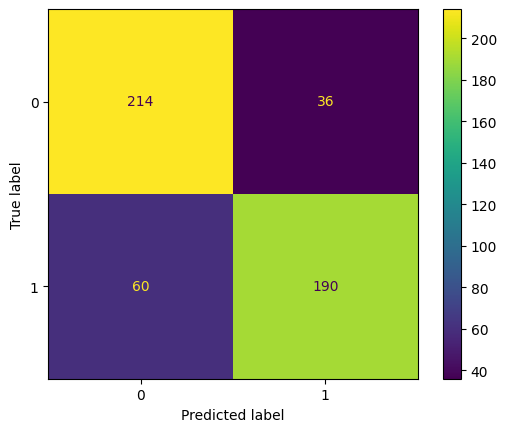

In [ ]:
# Own implementation test
voc, X_train = count_words(train_texts_splt)
_, X_test = count_words(val_texts, voc)

# Train
nbclassifier = NB()
nbclassifier.fit(X_train, train_labels_splt)

# Test
predictions = nbclassifier.predict(X_test)
score = nbclassifier.score(X_test, val_labels)

# Evaluation
print(f"Score: {score}")

# Gnerate confusion matrix
cm = confusion_matrix(val_labels, predictions, labels=nbclassifier.classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nbclassifier.classes)
disp.plot()

# Generate and print classification report
print(classification_report(val_labels, predictions, digits=3))

Score: 0.794
              precision    recall  f1-score   support

           0      0.767     0.844     0.804       250
           1      0.827     0.744     0.783       250

    accuracy                          0.794       500
   macro avg      0.797     0.794     0.793       500
weighted avg      0.797     0.794     0.793       500



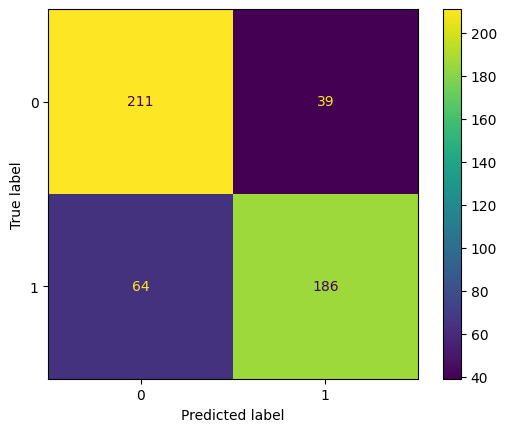

In [ ]:
## Sklearn implementation test
from sklearn.naive_bayes import MultinomialNB

# Preprocessing
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_texts_splt)
X_test = vectorizer.transform(val_texts)

# Train
nb_classifier = MultinomialNB(alpha=1.0)
nb_classifier.fit(X_train, train_labels_splt)

# Test
predictions = nb_classifier.predict(X_test)
score = nb_classifier.score(X_test, val_labels)

print(f"Score: {score}")

# generate confusion matrix
cm = confusion_matrix(val_labels, predictions, labels=nb_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb_classifier.classes_)
disp.plot()

# Generate and print classification report
print(classification_report(val_labels, predictions, digits=3))

<div class='alert alert-block alert-warning'>
            Questions:</div>
            
Let us look at the *features* built by the ```vectorizer```. What seems to be the issue ?

### Answers:
The issue with the features built by the vectorizer is that it seems to be including numerical values, digits, and alphanumeric sequences as features. These features will not be meaningful for sentiment analysis. Moreover, we can see that some words like "16th" and "16ème" represent pretty much the same thing but are being considering as different features, which increase the memory usage.

In [ ]:
print(vectorizer.get_feature_names_out()[:100])

['00' '000' '00001' '007' '0079' '0080' '0083' '02' '05' '07' '08' '10'
 '100' '1000' '100m' '101' '102' '103' '105' '10th' '10yr' '11' '110' '12'
 '120' '123' '125' '12s' '12th' '13' '130' '134' '13th' '14' '145' '147'
 '14ieme' '14th' '15' '150' '16' '161' '1692' '16th' '16ème' '17' '1700'
 '1794' '17th' '18' '180' '1814' '1824' '1840' '1850' '1864' '1880'
 '1880s' '1889' '1892' '1895' '1897' '18th' '19' '1902' '1907' '1910'
 '1911' '1912' '1918' '1920' '1920s' '1921' '1922' '1924' '1925' '1927'
 '1928' '1929' '1930' '1930s' '1931' '1932' '1933' '1934' '1935' '1936'
 '1937' '1938' '1939' '1940' '1940s' '1941' '1942' '1943' '1944' '1945'
 '1946' '1947' '1948']


### Improving representations

Mainly, the arguments of the class ```vectorizer``` will allow us to easily change the way our textual data is represented. Let us try to work on our *Bag-of-words* representations:
   
#### Do not take into account words that are too frequent:

You can use the argument ```max_df=1.0``` to change the amount of words taken into account. 

#### Try different granularities:

Rather than just counting words, we can count sequences of words - limited in size, of course. 
We call a sequence of $n$ words a $n$-gram: let's try using 2 and 3-grams (bi- and trigrams).
We can also try to use character sequences instead of word sequences.

We will be interested in the options ```analyze='word'``` and ```ngram_range=(1, 2)``` which we'll change to alter the granularity: **obtain classification results with them**.

Again: using these ways of getting more features from our text will probably have more impact if we do not have much training data to begin with ! To accelerate experiments, use the ```Pipeline``` tool from scikit-learn. 

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
pipeline_base = Pipeline([
    ('vect', CountVectorizer(max_features=30000, analyzer='word', stop_words=None)),
    ('clf', MultinomialNB()),
])
pipeline_base.fit(train_texts_splt, train_labels_splt)
val_pred = pipeline_base.predict(val_texts)
print(classification_report(val_labels, val_pred, digits=3))

              precision    recall  f1-score   support

           0      0.767     0.844     0.804       250
           1      0.827     0.744     0.783       250

    accuracy                          0.794       500
   macro avg      0.797     0.794     0.793       500
weighted avg      0.797     0.794     0.793       500



In [ ]:
max_df_values = np.arange(0.05, 1, 0.05, dtype=float)
best_score = 0
best_pipeline = None
best_max_df = None

for max_df_value in max_df_values:
    pipeline_mod_different_max_values = Pipeline([
        ('vect', CountVectorizer(max_df=max_df_value, max_features=30000, analyzer='word', stop_words=None)),
        ('clf', MultinomialNB()),
    ])
    pipeline_mod_different_max_values.fit(train_texts_splt, train_labels_splt)
    val_pred = pipeline_mod_different_max_values.predict(val_texts)
    score = pipeline_mod_different_max_values.score(val_texts, val_labels)
    print('Accuracy with max_df = {}: {}'.format(max_df_value, score))
    
    if score > best_score:
        best_score = score
        best_pipeline = pipeline_mod_different_max_values
        best_max_df = max_df_value

print('\nBest score:', best_score)
print('Best max_df value:', best_max_df)

# Print classification report for the best pipeline
print("\nClassification Report for Best Pipeline:")
val_pred_best = best_pipeline.predict(val_texts)
print(classification_report(val_labels, val_pred_best, digits=3))

Accuracy with max_df = 0.05: 0.776
Accuracy with max_df = 0.1: 0.8
Accuracy with max_df = 0.15000000000000002: 0.792
Accuracy with max_df = 0.2: 0.792
Accuracy with max_df = 0.25: 0.808
Accuracy with max_df = 0.3: 0.804
Accuracy with max_df = 0.35000000000000003: 0.812
Accuracy with max_df = 0.4: 0.81
Accuracy with max_df = 0.45: 0.812
Accuracy with max_df = 0.5: 0.808
Accuracy with max_df = 0.55: 0.806
Accuracy with max_df = 0.6000000000000001: 0.806
Accuracy with max_df = 0.6500000000000001: 0.792
Accuracy with max_df = 0.7000000000000001: 0.792
Accuracy with max_df = 0.7500000000000001: 0.786
Accuracy with max_df = 0.8: 0.786
Accuracy with max_df = 0.8500000000000001: 0.788
Accuracy with max_df = 0.9000000000000001: 0.79
Accuracy with max_df = 0.9500000000000001: 0.788

Best score: 0.812
Best max_df value: 0.35000000000000003

Classification Report for Best Pipeline:
              precision    recall  f1-score   support

           0      0.785     0.860     0.821       250
        

Selecting the argument ```ngram_range=(1,2)```:

In [ ]:
# Define a modified pipeline with CountVectorizer and MultinomialNB
pipeline_modified = Pipeline([
    ('vect', CountVectorizer(max_features=30000, analyzer='word', stop_words=None,
                             ngram_range=(1, 2))),  # Modify parameters here
    ('clf', MultinomialNB()),   
])

# Fit the modified pipeline to the training data and make predictions on the validation data
pipeline_modified.fit(train_texts_splt, train_labels_splt)
val_pred_modified = pipeline_modified.predict(val_texts)

# Print classification report for the modified pipeline
print("Classification Report for Modified Pipeline:")
print(classification_report(val_labels, val_pred_modified, digits=3))

Classification Report for Modified Pipeline:
              precision    recall  f1-score   support

           0      0.803     0.832     0.817       250
           1      0.826     0.796     0.811       250

    accuracy                          0.814       500
   macro avg      0.814     0.814     0.814       500
weighted avg      0.814     0.814     0.814       500



Selecting the argument ```ngram_range=(1,3)```:

In [ ]:
# Define a modified pipeline with CountVectorizer and MultinomialNB
pipeline_modified = Pipeline([
    ('vect', CountVectorizer(max_features=30000, analyzer='word', stop_words=None,
                             ngram_range=(1, 3))),  # Modify parameters here
    ('clf', MultinomialNB()),
])

# Fit the modified pipeline to the training data and make predictions on the validation data
pipeline_modified.fit(train_texts_splt, train_labels_splt)
val_pred_modified = pipeline_modified.predict(val_texts)

# Print classification report for the modified pipeline
print("Classification Report for Modified Pipeline:")
print(classification_report(val_labels, val_pred_modified, digits=3))

Classification Report for Modified Pipeline:
              precision    recall  f1-score   support

           0      0.811     0.824     0.817       250
           1      0.821     0.808     0.815       250

    accuracy                          0.816       500
   macro avg      0.816     0.816     0.816       500
weighted avg      0.816     0.816     0.816       500



#### Tf-idf:

This is the product of the frequency of the term (TF) and its inverse frequency in documents (IDF).
This method is usually used to measure the importance of a term $i$ in a document $j$ relative to the rest of the corpus, from a matrix of occurrences $ words \times documents$. Thus, for a matrix $\mathbf{T}$ of $|V|$ terms and $D$ documents:
$$\text{TF}(T, w, d) = \frac{T_{w,d}}{\sum_{w'=1}^{|V|} T_{w',d}} $$

$$\text{IDF}(T, w) = \log\left(\frac{D}{|\{d : T_{w,d} > 0\}|}\right)$$

$$\text{TF-IDF}(T, w, d) = \text{TF}(X, w, d) \cdot \text{IDF}(T, w)$$

It can be adapted to our case by considering that the context of the second word is the document. However, TF-IDF is generally better suited to low-density matrices, since it will penalize terms that appear in a large part of the documents. 

Experiment with this new representations using the ```TfidfTransformer``` applied on top of ```CountVectorizer```.

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
#esto lo puse yo
# Define a pipeline with CountVectorizer, TfidfTransformer, and MultinomialNB
pipeline_tfidf = Pipeline([
    ('vect', CountVectorizer(max_features=30000, analyzer='word', stop_words=None)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

# Fit the pipeline to the training data and make predictions on the validation data
pipeline_tfidf.fit(train_texts_splt, train_labels_splt)
val_pred_tfidf = pipeline_tfidf.predict(val_texts)

# Print classification report for the pipeline with TF-IDF representation
print("Classification Report for Pipeline with TF-IDF Representation:")
print(classification_report(val_labels, val_pred_tfidf, digits=3))

Classification Report for Pipeline with TF-IDF Representation:
              precision    recall  f1-score   support

           0      0.760     0.912     0.829       250
           1      0.890     0.712     0.791       250

    accuracy                          0.812       500
   macro avg      0.825     0.812     0.810       500
weighted avg      0.825     0.812     0.810       500



## IV - More pre-processing: getting vocabularies

For more flexibility, we will implement separately a function returning the vocabulary. Here we will have to be able to control its size, either by indicating a **maximum number of words**, or a **minimum number of occurrences** to take the words into account. **We add, at the end, an "unknown" word that will replace all the words that do not appear in our "limited" vocabulary**.
<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
def vocabulary(corpus, count_threshold=5, voc_threshold=10000):
    """    
    Function using word counts to build a vocabulary - can be improved with a second parameter for 
    setting a frequency threshold
    Params:
        corpus (list of strings): corpus of sentences
        count_threshold (int): number of occurences necessary for a word to be included in the vocabulary
        voc_threshold (int): maximum size of the vocabulary. Use "0" to indicate no limit 
    Returns:
        vocabulary (dictionary): keys: list of distinct words across the corpus
                                 values: indexes corresponding to each word sorted by frequency   
        vocabulary_word_counts (dictionary): keys: list of distinct words across the corpus
                                             values: corresponding counts of words in the corpus
    """
    word_counts = {}
    for sent in corpus:
        # Tokenize the sentence
        words = sent.split()
        # Count word frequencies
        for word in words:
            word_counts[word] = word_counts.get(word, 0) + 1

    # Filter word counts based on count_threshold
    filtered_word_counts = {word: count for word, count in word_counts.items() if count >= count_threshold}
    # Sort words based on frequency
    sorted_words = sorted(filtered_word_counts.keys(), key=lambda x: filtered_word_counts[x], reverse=True)
    # Filter words based on voc_threshold
    if voc_threshold > 0:
        filtered_words = sorted_words[:voc_threshold]
    else:
        filtered_words = sorted_words
    # Add 'UNK' for unknown words
    filtered_words.append('UNK')
    # Create vocabulary with word indices
    vocabulary = {word: idx for idx, word in enumerate(filtered_words)}
    # Create a dictionary to store word counts for words in the vocabulary
    vocabulary_word_counts = {word: filtered_word_counts.get(word, 0) for word in vocabulary}

    return vocabulary, vocabulary_word_counts

In [ ]:
# Example for testing:

corpus = ['I walked down down the boulevard',
          'I walked down the avenue',
          'I ran down the boulevard',
          'I walk down the city',
          'I walk down the the avenue']

voc, counts = vocabulary(corpus, count_threshold = 3)
print(voc)
print(counts)
print('\n\n')

# We expect something like this:
# (In this example, we don't count 'UNK' unknown words, but you can if you want to. 
# How useful it may be depends on the data -> we will use the counts later with word2vec, keep that in mind) 
#  {'down': 0, 'the': 1, 'i': 2, 'UNK': 3}
#  {'down': 6, 'the': 6, 'i': 5, 'UNK': 0}

voc, counts = vocabulary(corpus, count_threshold = 0)
#voc, counts = vocabulary(corpus)
print(voc)
print(counts)

# We expect something like this:
#  {'down': 0, 'the': 1, 'i': 2, 'walked': 3, 'boulevard': 4, 'avenue': 5, 'walk': 6, 'ran': 7, 'city': 8, 'UNK': 9}
#  {'down': 6, 'the': 6, 'i': 5, 'walked': 2, 'boulevard': 2, 'avenue': 2, 'walk': 2, 'ran': 1, 'city': 1, 'UNK': 0}

{'down': 0, 'the': 1, 'I': 2, 'UNK': 3}
{'down': 6, 'the': 6, 'I': 5, 'UNK': 0}



{'down': 0, 'the': 1, 'I': 2, 'walked': 3, 'boulevard': 4, 'avenue': 5, 'walk': 6, 'ran': 7, 'city': 8, 'UNK': 9}
{'down': 6, 'the': 6, 'I': 5, 'walked': 2, 'boulevard': 2, 'avenue': 2, 'walk': 2, 'ran': 1, 'city': 1, 'UNK': 0}


### Quick study of the data

We would like to get an idea of what's in these film reviews. So we'll get the vocabulary (in full) and represent the frequencies of the words, in order (be careful, you'll have to use a logarithmic scale): we should find back Zipf's law. This will give us an idea of the size of the vocabulary we will be able to choose: it's a matter of making a compromise between the necessary resources (size of the objects in memory) and the amount of information we can get from them (rare words can bring a lot of information, but it's difficult to learn good representations of them, because they are rare!).  

<div class='alert alert-block alert-info'>
            Code:</div>

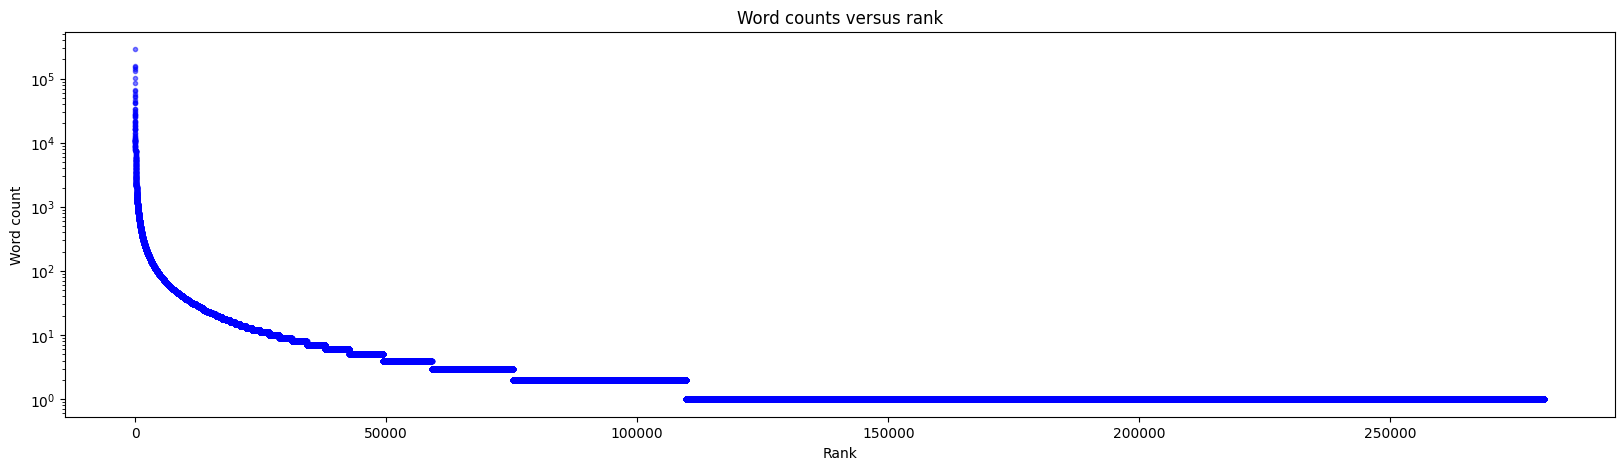

Vocabulary size: 280618
Part of the corpus by taking the "x" most frequent words ?
For the top 100 most frequent words: 45.64%
For the top 1000 most frequent words: 68.36%
For the top 5000 most frequent words: 81.52%


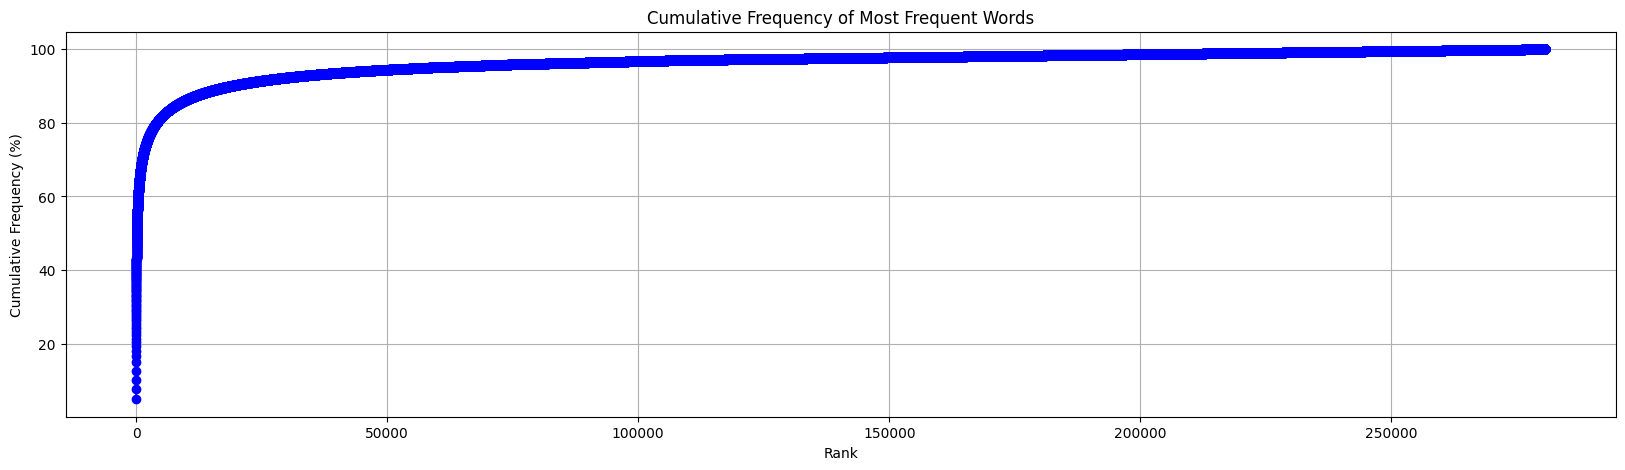

In [ ]:
# We would like to display the curve of word frequencies given their rank (index) in the vocabulary
vocab, word_counts = vocabulary(train_texts, count_threshold=0, voc_threshold=0)
# Sort the word counts in descending order
sorted_word_counts = sorted(word_counts.values(), reverse=True)

# We can for example use the function plt.scatter()
plt.figure(figsize=(20,5))
plt.title('Word counts versus rank')
#
#  To fill in !
#
plt.scatter(range(1, len(sorted_word_counts) + 1), sorted_word_counts, marker='.', color='blue', alpha=0.5)
plt.title('Word counts versus rank')
plt.xlabel('Rank')
plt.ylabel('Word count')

plt.yscale('log')
plt.show()

'''
# Calculate the cumulative sum of frequencies
cumulative_sum = [sum(sorted_word_counts[:k]) for k in range(1, len(sorted_word_counts) + 1)]
'''
cumulative_sum = np.cumsum(sorted_word_counts)

# We would like to know how much of the data is represented by the 'k' most frequent words
print('Vocabulary size: %i' % len(vocab))
print('Part of the corpus by taking the "x" most frequent words ?')

for k in [100, 1000, 5000]:
    part_of_corpus = cumulative_sum[k - 1] / sum(sorted_word_counts)
    print(f'For the top {k} most frequent words: {part_of_corpus:.2%}')

# Calculate cumulative frequency
cumulative_frequency = np.cumsum(sorted_word_counts) / np.sum(sorted_word_counts) * 100

# Plot the cumulative frequency
fig, ax = plt.subplots(figsize=(20, 5))
plt.plot(range(1, len(cumulative_frequency) + 1), cumulative_frequency, marker='o', color='blue')
plt.title('Cumulative Frequency of Most Frequent Words')
plt.xlabel('Rank')
plt.ylabel('Cumulative Frequency (%)')
plt.grid(True)
plt.show()
plt.close()

<div class='alert alert-block alert-warning'>
            Questions:</div>
            
Word2vec's implementation cuts the vocabulary size by using **only words with at least 5 occurences**, by default. What vocabulary size would it give here ? Does it seem like a good compromise, looking at the graph ?

### Answers:
The original vocabulary size found is 280618 and using at least 5 occurences criteria one gets 49346, which is way smaller (~18% of the original size), what enhances computational efficiency. **This amount seems like a good compromise as the region with less than 5 occurrences is starting to flatten out**. Rare words in the corpus might not have sufficient statistical significance to contribute meaningfully to the word embeddings. Moreover, the model may not learn robust representations for these words,leading to less reliable embeddings. Finally these rare words may also be just noise introduced to the model. 

### With pre-processing tools from NLTK

We are now going to pre-process our textual data. **Note that this still will only be useful if we do not have a lot of training data to begin with !**

#### Stemming 

Allows to go back to the root of a word: you can group different words around the same root, which facilitates generalization. Use:
```from nltk import SnowballStemmer```

In [ ]:
from nltk import SnowballStemmer
stemmer = SnowballStemmer("english")

**Example:**

In [ ]:
words = ['singers', 'cat', 'generalization', 'philosophy', 'psychology', 'philosopher']
for word in words:
    print('word : %s ; stemmed : %s' %(word, stemmer.stem(word)))

word : singers ; stemmed : singer
word : cat ; stemmed : cat
word : generalization ; stemmed : general
word : philosophy ; stemmed : philosophi
word : psychology ; stemmed : psycholog
word : philosopher ; stemmed : philosoph


**Data transformation:**

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
def stem(texts):
    stemmer = SnowballStemmer("english")
    stemmed_texts = []
    for text in texts:
        words = text.split()
        stemmed_words = [stemmer.stem(word) for word in words]
        stemmed_text = ' '.join(stemmed_words)
        stemmed_texts.append(stemmed_text)
    texts = stemmed_texts
    return texts

In [ ]:
# Sample texts before stemming
texts_before_stemming = [
    "singer sings beautifully",
    "cats are cute pets",
    "generalization is important in science",
    "philosophy explores the nature of existence",
    "psychology studies the human mind",
    "philosophers contemplate deep questions"
]

# Apply stemming
texts_after_stemming = stem(texts_before_stemming)

# Print the original and stemmed texts
for original, stemmed in zip(texts_before_stemming, texts_after_stemming):
    print("Original: ", original)
    print("Stemmed: ", stemmed)
    print()

Original:  singer sings beautifully
Stemmed:  singer sing beauti

Original:  cats are cute pets
Stemmed:  cat are cute pet

Original:  generalization is important in science
Stemmed:  general is import in scienc

Original:  philosophy explores the nature of existence
Stemmed:  philosophi explor the natur of exist

Original:  psychology studies the human mind
Stemmed:  psycholog studi the human mind

Original:  philosophers contemplate deep questions
Stemmed:  philosoph contempl deep question



#### Part of speech tags

To generalize, we can also use the Part of Speech (POS) of the words, which will allow us to filter out information that is potentially not useful to the model. We will retrieve the POS of the words using the functions:
```pos_tag```

In [ ]:
import nltk
from nltk import pos_tag, word_tokenize

**Example:**

In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

pos_tag(word_tokenize(('I am Sam')))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aleja\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\aleja\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('I', 'PRP'), ('am', 'VBP'), ('Sam', 'NNP')]

**Data transformation:** only keep nouns, verbs, adverbs, and adjectives (```['NN', 'VB', 'JJ', 'RB']```) for our model.

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
def pos_tag_filter(X, good_tags=['NN', 'VB', 'JJ', 'RB']):
    X_pos = []
    for text in X:
        tagged_text = pos_tag(word_tokenize(text))
        filtered_text = ' '.join(word for word, tag in tagged_text if tag in good_tags)
        X_pos.append(filtered_text)
    return X_pos

In [ ]:
# Test the function with sample texts
sample_texts = [
    "The quick brown fox jumps over the lazy dog.",
    "I am learning natural language processing with Python.",
    "She quickly ran to the store to buy some groceries."
]

# Apply the function
filtered_texts = pos_tag_filter(sample_texts)

# Display the filtered texts
for original_text, filtered_text in zip(sample_texts, filtered_texts):
    print(f"Original Text: {original_text}")
    print(f"Filtered Text: {filtered_text}")
    print()

Original Text: The quick brown fox jumps over the lazy dog.
Filtered Text: quick brown fox lazy dog

Original Text: I am learning natural language processing with Python.
Filtered Text: natural language processing

Original Text: She quickly ran to the store to buy some groceries.
Filtered Text: quickly store buy



### Application

<div class='alert alert-block alert-warning'>
            Questions:</div>

Re-draw the Zipf distribution of our data **after reducing their vocabulary with these functions**. How is it affected ? How do you think it could affect results here ?

### Answers:
The distribution is still following Zipf law but we can notice it suffered a downscaling.
Stemming reduces words to their root forms. This can improve the model's ability to generalize patterns in text data.
Pos_tag_filter helps reducing noise in the data by excluding words that may not contribute much to the overall meaning of the text.
However, stemming and Pos_tag_filter can also lead to a loss of information. Words with different meanings but the same stem may be treated identically, potentially leading to ambiguity in the model's predictions.
        
<div class='alert alert-block alert-info'>
            Code:</div>

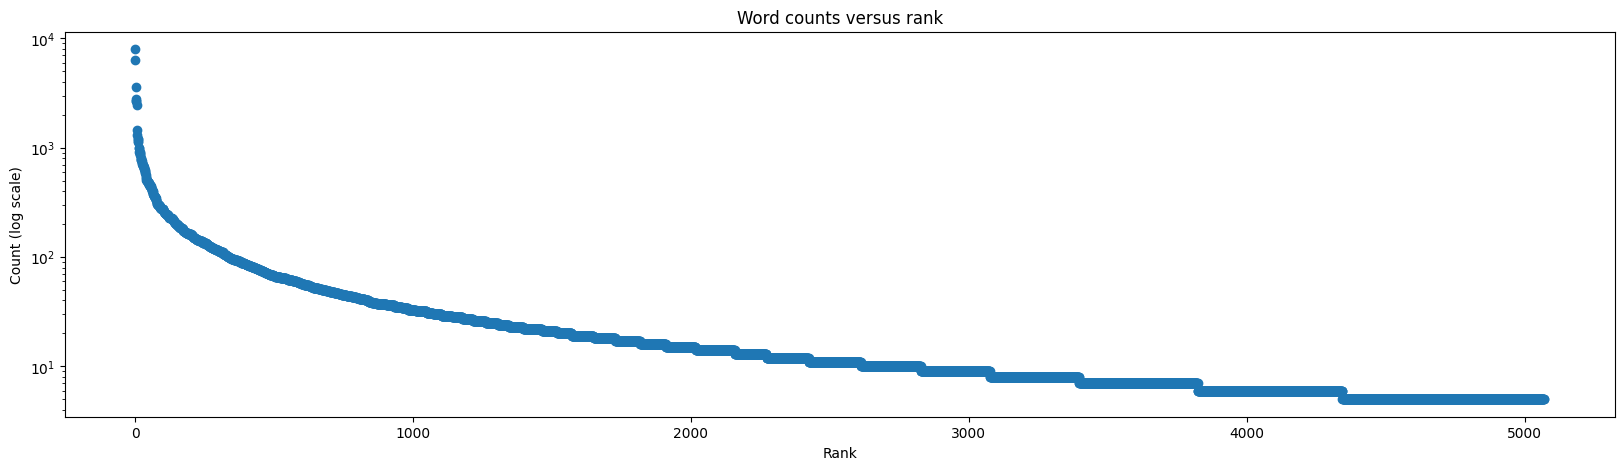

Vocabulary size: 5071
Part of the corpus by taking the "x" most frequent words ?
Part of the corpus by taking the 1000 most frequent words: 0.77


In [ ]:
stemmed_train_texts = stem(train_texts_splt)
pos_tagged_train_texts = pos_tag_filter(stemmed_train_texts)

vocab, word_counts = vocabulary(pos_tagged_train_texts, count_threshold=5, voc_threshold=0)

plt.figure(figsize=(20, 5))
plt.title("Word counts versus rank")
plt.scatter(range(len(word_counts)), sorted(word_counts.values(), reverse=True))
plt.yscale("log")
plt.xlabel("Rank")
plt.ylabel("Count (log scale)")
plt.show()
plt.close()

print(f"Vocabulary size: {len(vocab)}")
print('Part of the corpus by taking the "x" most frequent words ?')

k = 1000

# Calculate the total count of all words
total_word_count = sum(word_counts.values())

# Sort the word counts in descending order and take the top k counts
top_k_word_counts = sorted(word_counts.values(), reverse=True)[:k]

# Calculate the sum of the top k word counts
sum_top_k_word_counts = sum(top_k_word_counts)

# Calculate the expected proportion
expected_proportion = sum_top_k_word_counts / total_word_count

print(f"Part of the corpus by taking the {k} most frequent words: {expected_proportion:.2f}")